In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
from urllib.parse import urlparse

# Monte Carlo Weights
To calculate the weights it's necessary to get the production rate for each file.
I commented out the functions to create the csv since I already got the needed csv

In [2]:
def extract_table(url):

    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, "html.parser")
    
    table = soup.find("table")  # the big summary table
    return table

url = "https://ild.ngt.ndu.ac.jp/mc-prod/prodmon/prodsum-mc2020.html"

# Since I already created the csv
#table = extract_table(url)

In [3]:
rows = []
current_rate = None

pattern = r'(\d+)\s*/\s*(\d+)'

def create_csv():
    for tr in table.find_all("tr"):
        text = tr.get_text(strip=True)
        # Detect section header with produced rate
        if ":" in text and "Produced rate" in text:
            # e.g., "higgs_inclusive : Produced rate 99.96% (…)"
            parts = text.split(":")
            current_rate = parts[1].strip().split()[2]
    
            matches = re.findall(pattern, parts[1].strip())
    
            # If you expect only one occurrence, you can take the first match:
            if matches:
                prod, gen = matches[0]          # strings representing the numbers
                prod_val = int(prod)            # convert to integers if needed
                gen_val  = int(gen)
    
                print(f"{current_rate}")
                print(f"N_Prod = {prod_val}")
                print(f"N_Gen  = {gen_val}")
            else:
                print("No number pair found.")
        elif tr.find_all("td"):
            tds = [td.get_text(strip=True) for td in tr.find_all("td")]
            # Build row with current_rate
            rows.append([current_rate,prod_val,gen_val] + tds)
    
    
    # Write CSV
    with open("250-SetA-with-rate.csv","w",newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ProducedRate","n_prod","n_gen","pol","processID","NbEvents","int.lumi",
                         "Done%","ElogID","ProdIDs"])
        writer.writerows(rows)

#create_csv()

In [4]:
# Option 1 – absolute path (replace USERNAME with your actual login name)
csv_path = "/home/USERNAME/Documents/mestrado/code/tomaz-example/data/mc_tree/250-SetA-with-rate.csv"

# Option 2 – expand a tilde‑prefixed path
csv_path = os.path.expanduser("~/Documents/mestrado/code/tomaz-example/data/mc_tree/250-SetA-with-rate.csv")

# Load the CSV
df = pd.read_csv(csv_path)
df.head()

,ProducedRate,n_prod,n_gen,process_type,pol,processID,NbEvents,int.lumi(1/fb),Done %,ElogID(s),ProdIDs of DST and REC files
0,99.96%,6997400,7000000,e1e1h,eL.pL,402013,500000,801943,100.0,348,"DST=15095,15096;REC=15095"
1,99.96%,6997400,7000000,e1e1h,eL.pR,402001,500000,28294,100.0,347,"DST=15089,15090;REC=15089"
2,99.96%,6997400,7000000,e1e1h,eR.pL,402002,500000,44887,100.0,347,"DST=15089,15090;REC=15089"
3,99.96%,6997400,7000000,e1e1h,eR.pR,402014,498800,800018,99.8,348,"DST=15095,15096;REC=15095"
4,99.96%,6997400,7000000,e2e2h,eL.pR,402003,500000,29462,100.0,347,"DST=15089,15090;REC=15089"


In [5]:


# ----------------------------------------------------------------
# 1) Configuration
# ----------------------------------------------------------------

BASE_URL = "https://ild.ngt.ndu.ac.jp/elog/genmeta/"
CSV_FILE = "cross_sections_250GeV.csv"

# ID range to scan (inclusive)
START_ID = 3897
END_ID   = 718

# ----------------------------------------------------------------
# 2) Ensure CSV has a header if it doesn't exist
# ----------------------------------------------------------------
try:
    with open(CSV_FILE, "r") as f:
        existing = True
except FileNotFoundError:
    existing = False

if not existing:
    with open(CSV_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "process_id", "dataset_label",
            "xsect_pb", "xsect_error_pb",
            "int_lumi_fb", "energy_GeV", "source_url"
        ])

# ----------------------------------------------------------------
# 3) Scraping loop
# ----------------------------------------------------------------
def safe_get(url):
    try:
        resp = requests.get(url, timeout=15)
        if resp.status_code == 200:
            return resp.text
    except requests.RequestException as e:
        print(f"  ❌ Failed to fetch {url}: {e}")
    return None

def extract_hidden(soup, name):
    tag = soup.find("input", {"name": name})
    return tag["value"] if tag and "value" in tag.attrs else None

def extract_process_id(raw_val):
    if raw_val:
        inner_text = BeautifulSoup(raw_val, "html.parser").get_text().strip()
        # Extract first number we find
        for part in inner_text.split():
            if part.isdigit():
                return part
    return None

def extract_xsect():
    for i in range(START_ID, END_ID - 1, -1):
        url = f"{BASE_URL}{i}"
        print(f"Processing {url}")
    
        html = safe_get(url)
        if not html:
            print("  Skipped (no content)")
            continue
    
        soup = BeautifulSoup(html, "html.parser")
    
        # Must check energy first
        energy = extract_hidden(soup, "Energy")
        if energy is None or energy.strip() != "250":
            print("  Skipped (Energy != 250)")
            continue
    
        # Extract fields
        raw_pid     = extract_hidden(soup, "process_id")
        process_id  = extract_process_id(raw_pid)
    
        xsect       = extract_hidden(soup, "xsect")
        xsect_err   = extract_hidden(soup, "xsect_error")
        intlumi     = extract_hidden(soup, "IntLumi")
    
        # Must have at least cross section & IntLumi
        if xsect is None or intlumi is None:
            print("  Skipped (missing xsect/IntLumi)")
            continue
    
        try:
            xsect_pb  = float(xsect)
        except ValueError:
            xsect_pb  = None
    
        try:
            xsect_err_pb = float(xsect_err) if xsect_err else None
        except ValueError:
            xsect_err_pb = None
    
        try:
            int_lumi_fb = float(intlumi)
        except ValueError:
            int_lumi_fb = None
    
        dataset_label = process_id if process_id else urlparse(url).path.split("/")[-1]
    
        # Append to CSV
        with open(CSV_FILE, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                process_id,
                dataset_label,
                xsect_pb,
                xsect_err_pb,
                int_lumi_fb,
                energy,
                url
            ])
    
        print(f"  ✔ Added: pid={process_id}, xsect={xsect_pb}, IntLumi={int_lumi_fb}")
    
        # Be gentle on the server
        time.sleep(0.3)

    print("\nDone scanning all IDs.")
    print(f"Updated CSV: {CSV_FILE}")

#extract_xsect()

In [6]:
def merge_csv():
    # ------------------------------------------------------------------
    # 1️⃣ Load the CSVs
    # ------------------------------------------------------------------
    # Replace these paths with the actual locations of your files
    df_a = pd.read_csv("250-SetA-with-rate.csv")   # contains column named "processID"
    df_b = pd.read_csv("cross_sections_250GeV.csv")   # contains column named "process_id"
    
    # ------------------------------------------------------------------
    # 2️⃣ Align the key column names
    # ------------------------------------------------------------------
    # We'll standardise everything to "process_id"
    df_a = df_a.rename(columns={"processID": "process_id"})   # rename in df_a
    # df_b already uses "process_id", so no change needed there
    
    # ------------------------------------------------------------------
    # 3️⃣ Merge / combine the data
    # ------------------------------------------------------------------
    # Choose the join type you need:
    #   - "inner": keep only rows where the key exists in BOTH files
    #   - "left": keep all rows from df_a and attach matching rows from df_b
    #   - "right": keep all rows from df_b and attach matching rows from df_a
    #   - "outer": keep every row from both sides (fills missing values with NaN)
    merged = pd.merge(
        left=df_a,
        right=df_b,
        on="process_id",
        how="inner",          # ← change to left/right/outer if desired
        suffixes=("_a", "_b") # helps differentiate duplicate column names
    )
    
    # ------------------------------------------------------------------
    # 4️⃣ Drop columns you don’t need
    # ------------------------------------------------------------------
    # Example: suppose you only care about these three columns
    cols_to_keep = ["process_id"]
    cleaned = merged[cols_to_keep]
    
    # If you have a longer list of columns to discard instead:
    # cols_to_drop = ["unnecessary_col1", "temp_flag", "debug_info"]
    # cleaned = merged.drop(columns=cols_to_drop)
    
    # ------------------------------------------------------------------
    # 5️⃣ Save the result (optional)
    # ------------------------------------------------------------------
    merged.to_csv("combined_cleaned.csv", index=False)
    
    print("✅ Merge complete! Output saved to 'combined_cleaned.csv'")

#merge_csv()

In [7]:
df = pd.read_csv("combined_cleaned.csv")
print(df.columns)
df.head()

Index(['ProducedRate', 'n_prod', 'n_gen', 'process_type', 'pol', 'process_id',
       'NbEvents', 'int.lumi(1/fb)', 'Done %', 'ElogID(s)',
       'ProdIDs of DST and REC files', 'dataset_label', 'xsect_pb',
       'xsect_error_pb', 'int_lumi_fb', 'energy_GeV', 'source_url'],
      dtype='object')


,ProducedRate,n_prod,n_gen,process_type,pol,process_id,NbEvents,int.lumi(1/fb),Done %,ElogID(s),ProdIDs of DST and REC files,dataset_label,xsect_pb,xsect_error_pb,int_lumi_fb,energy_GeV,source_url
0,99.96%,6997400,7000000,e1e1h,eL.pL,402013,500000,801943,100.0,348,"DST=15095,15096;REC=15095",402013,0.623485,0.000474,801943.3460,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3409
1,99.96%,6997400,7000000,e1e1h,eL.pR,402001,500000,28294,100.0,347,"DST=15089,15090;REC=15089",402001,17.671491,0.022800,28294.1604,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3410
2,99.96%,6997400,7000000,e1e1h,eR.pL,402002,500000,44887,100.0,347,"DST=15089,15090;REC=15089",402002,11.138876,0.014300,44887.8325,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3411
3,99.96%,6997400,7000000,e1e1h,eR.pR,402014,498800,800018,99.8,348,"DST=15095,15096;REC=15095",402014,0.623485,0.000474,801943.3460,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3412
4,99.96%,6997400,7000000,e2e2h,eL.pR,402003,500000,29462,100.0,347,"DST=15089,15090;REC=15089",402003,16.970655,0.013800,29462.6224,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3413


📌 Important details
📍 Cross-section units

ELOG logs usually report 
𝜎
σ in pb (picobarns).

Integrated luminosity from the ILD summary is in fb⁻¹ (femtobarns⁻¹).
To combine:

So multiply cross section by 1000 before weighting.

In [8]:
N_events = 20_000
event_weight = (df["xsect_pb"] * df["int_lumi_fb"]) / df["NbEvents"]
print(event_weight)

0      1.000000
1      1.000000
2      1.000000
3      1.002406
4      1.000000
         ...   
444    1.000400
445    1.000000
446    1.000400
447    1.000000
448    1.000400
Length: 449, dtype: float64


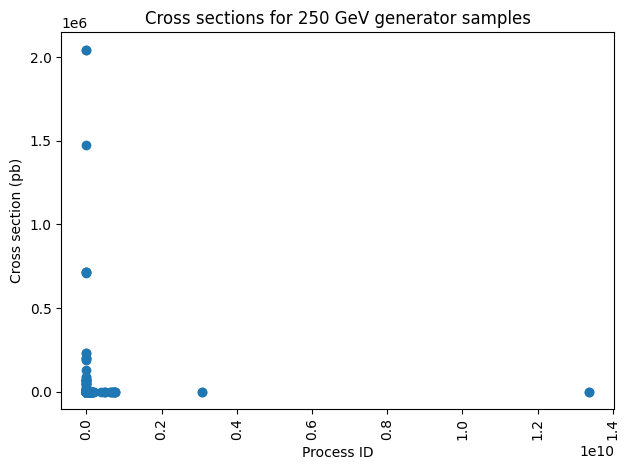

In [9]:

pids  = df["int.lumi(1/fb)"]
xsecs = df["xsect_pb"]
errs  = df["xsect_error_pb"]

plt.errorbar(pids, xsecs, yerr=errs, fmt='o')
plt.xlabel("Process ID")
plt.ylabel("Cross section (pb)")
plt.title("Cross sections for 250 GeV generator samples")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


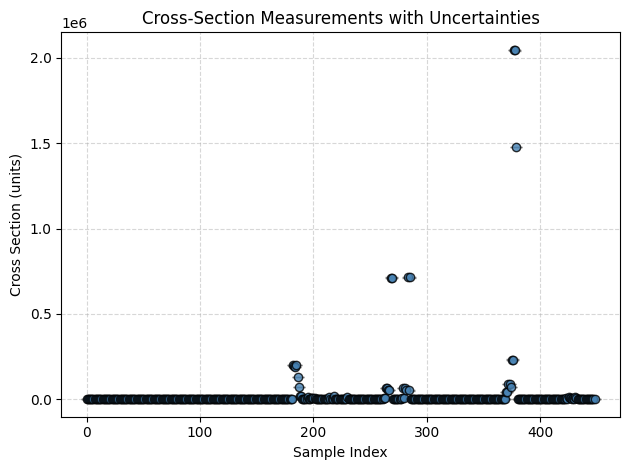

In [10]:
# errorbar() draws points with vertical error bars
plt.errorbar(df.index,
             xsecs,
             yerr=errs,
             fmt='o',                 # marker style
             ecolor='gray',           # colour of the error bars
             capsize=4,               # little caps on the ends
             markersize=6,
             markerfacecolor='steelblue',
             markeredgecolor='k',
             alpha=0.8)

# -------------------------------------------------
# 4️⃣  Labels, title, optional styling
# -------------------------------------------------
plt.title('Cross‑Section Measurements with Uncertainties')
plt.xlabel('Sample Index')
plt.ylabel('Cross Section (units)')   # replace “units” with the proper unit, e.g., barns
plt.grid(True, linestyle='--', alpha=0.5)

# -------------------------------------------------
# 5️⃣  Show / save the figure
# -------------------------------------------------
plt.tight_layout()
plt.savefig('cross_section_errorbars.png', dpi=300)   # optional output file
plt.show()

In [11]:
# Define patterns that correspond to muon final states:
# Here we assume 'e2e2h' refers to muon pair events from the Z in ZH.
muon_patterns = ["e2e2h", "e2e2h", "mu", "muon", "mumu"]

# Filter
muon_mask = df['process_type'].str.contains("e2e2h", case=False, na=False) \
             | df['pol'].str.contains("e2e2h", case=False, na=False)

muon_events = df[muon_mask].sort_values("xsect_pb", ascending=False)
muon_events.reset_index(inplace=True)

print(f"Found {len(muon_events)} muon-producing events")

# Optional: save to a separate file
muon_events.to_csv("muon_producing_events.csv", index=False)

Found 26 muon-producing events


In [12]:
muon_events.head()

,index,ProducedRate,n_prod,n_gen,process_type,pol,process_id,NbEvents,int.lumi(1/fb),Done %,ElogID(s),ProdIDs of DST and REC files,dataset_label,xsect_pb,xsect_error_pb,int_lumi_fb,energy_GeV,source_url
0,4,99.96%,6997400,7000000,e2e2h,eL.pR,402003,500000,29462,100.0,347,"DST=15089,15090;REC=15089",402003,16.970655,0.013800,29462.6224,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3413
1,5,99.96%,6997400,7000000,e2e2h,eR.pL,402004,500000,46001,100.0,347,"DST=15089,15090;REC=15089",402004,10.869108,0.008880,46001.9350,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3414
2,66,100.00%,33598600,33600000,e2e2h_bb,eL.pR,402137,100000,10124,100.0,385,"DST=15206,15207;REC=15206",402137,9.876921,0.008032,10124.6125,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3503
3,67,100.00%,33598600,33600000,e2e2h_bb,eR.pL,402146,100000,15808,100.0,385,"DST=15206,15207;REC=15206",402146,6.325821,0.005168,15808.2251,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3504
4,82,100.00%,33598600,33600000,e2e2h_ww,eL.pR,402140,500000,137675,100.0,385,"DST=15206,15207;REC=15206",402140,3.631720,0.002953,137675.8060,250,https://ild.ngt.ndu.ac.jp/elog/genmeta/3513


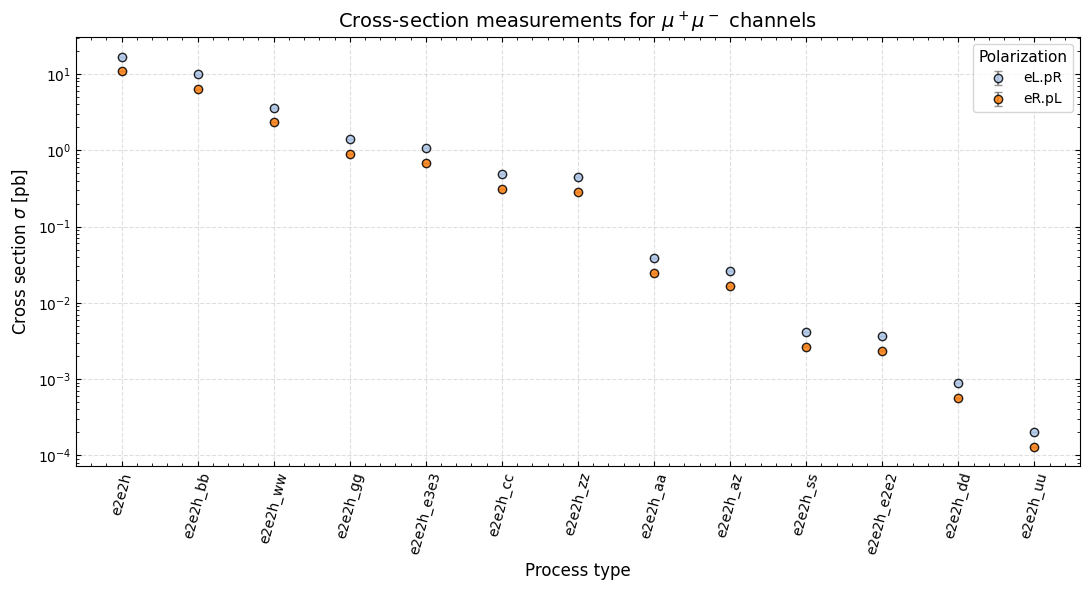

In [21]:
# Ensure process_type is categorical
muon_events["process_type"] = muon_events["process_type"].astype(str)

# Slightly smaller width
plt.figure(figsize=(11, 6))

# Loop over polarizations
for pol, subdf in muon_events.groupby("pol"):
    plt.errorbar(
        subdf["process_type"],
        subdf["xsect_pb"],
        yerr=subdf["xsect_error_pb"],
        fmt='o',
        label=pol,
        color=color_map[pol],
        ecolor='gray',
        capsize=3,
        markersize=6,
        markeredgecolor='k',
        alpha=0.85
    )

# -------------------------------------------------
# Styling
# -------------------------------------------------
plt.yscale("log")

plt.title(r"Cross-section measurements for $\mu^+\mu^-$ channels", fontsize=14)
plt.xlabel(r"Process type", fontsize=12)
plt.ylabel(r"Cross section $\sigma$ [pb]", fontsize=12)

plt.xticks(rotation=75)
plt.grid(True, linestyle='--', alpha=0.4)

# Legend INSIDE the plot
plt.legend(
    title=r"Polarization",
    frameon=True,
    fontsize=10,
    title_fontsize=11,
    loc="upper right"   # inside
)

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tight_layout()
plt.savefig("cross_section_errorbars.png", dpi=300)
plt.show()
